In [1]:
%load_ext rpy2.ipython
%matplotlib inline
from fbprophet import Prophet
import pandas as pd
from matplotlib import pyplot as plt
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv('../examples/example_wp_log_peyton_manning.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=366)

In [2]:
%%R
library(prophet)
df <- read.csv('../examples/example_wp_log_peyton_manning.csv')
m <- prophet(df)
future <- make_future_dataframe(m, periods=366)

Initial log joint probability = -19.4685
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


### Modeling Holidays and Special Events
If you have holidays or other recurring events that you'd like to model, you must create a dataframe for them. It has two columns (`holiday` and `ds`) and a row for each occurrence of the holiday. It must include all occurrences of the holiday, both in the past (back as far as the historical data go) and in the future (out as far as the forecast is being made). If they won't repeat in the future, Prophet will model them and then not include them in the forecast.

You can also include columns `lower_window` and `upper_window` which extend the holiday out to `[lower_window, upper_window]` days around the date. For instance, if you wanted to included Christmas Eve in addition to Christmas you'd include `lower_window=-1,upper_window=0`. If you wanted to use Black Friday in addition to Thanksgiving, you'd include `lower_window=0,upper_window=1`. You can also include a column `prior_scale` to set the prior scale separately for each holiday, as described below.

Here we create a dataframe that includes the dates of all of Peyton Manning's playoff appearances:

In [3]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

In [4]:
%%R
library(dplyr)
playoffs <- data_frame(
  holiday = 'playoff',
  ds = as.Date(c('2008-01-13', '2009-01-03', '2010-01-16',
                 '2010-01-24', '2010-02-07', '2011-01-08',
                 '2013-01-12', '2014-01-12', '2014-01-19',
                 '2014-02-02', '2015-01-11', '2016-01-17',
                 '2016-01-24', '2016-02-07')),
  lower_window = 0,
  upper_window = 1
)
superbowls <- data_frame(
  holiday = 'superbowl',
  ds = as.Date(c('2010-02-07', '2014-02-02', '2016-02-07')),
  lower_window = 0,
  upper_window = 1
)
holidays <- bind_rows(playoffs, superbowls)

Above we have include the superbowl days as both playoff games and superbowl games. This means that the superbowl effect will be an additional additive bonus on top of the playoff effect.

Once the table is created, holiday effects are included in the forecast by passing them in with the `holidays` argument. Here we do it with the Peyton Manning data from the Quickstart:

In [5]:
m = Prophet(holidays=holidays)
forecast = m.fit(df).predict(future)

In [6]:
%%R
m <- prophet(df, holidays = holidays)
forecast <- predict(m, future)

Initial log joint probability = -19.4685
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


The holiday effect can be seen in the `forecast` dataframe:

In [7]:
%%R
forecast %>% 
  select(ds, playoff, superbowl) %>% 
  filter(abs(playoff + superbowl) > 0) %>%
  tail(10)

           ds  playoff superbowl
17 2014-02-02 1.221621  1.201999
18 2014-02-03 1.898870  1.457674
19 2015-01-11 1.221621  0.000000
20 2015-01-12 1.898870  0.000000
21 2016-01-17 1.221621  0.000000
22 2016-01-18 1.898870  0.000000
23 2016-01-24 1.221621  0.000000
24 2016-01-25 1.898870  0.000000
25 2016-02-07 1.221621  1.201999
26 2016-02-08 1.898870  1.457674


In [8]:
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.229999,1.176410
2191,2014-02-03,1.900543,1.486962
2532,2015-01-11,1.229999,0.000000
2533,2015-01-12,1.900543,0.000000
2901,2016-01-17,1.229999,0.000000
2902,2016-01-18,1.900543,0.000000
2908,2016-01-24,1.229999,0.000000
2909,2016-01-25,1.900543,0.000000
2922,2016-02-07,1.229999,1.176410
2923,2016-02-08,1.900543,1.486962


The holiday effects will also show up in the components plot, where we see that there is a spike on the days around playoff appearances, with an especially large spike for the superbowl:

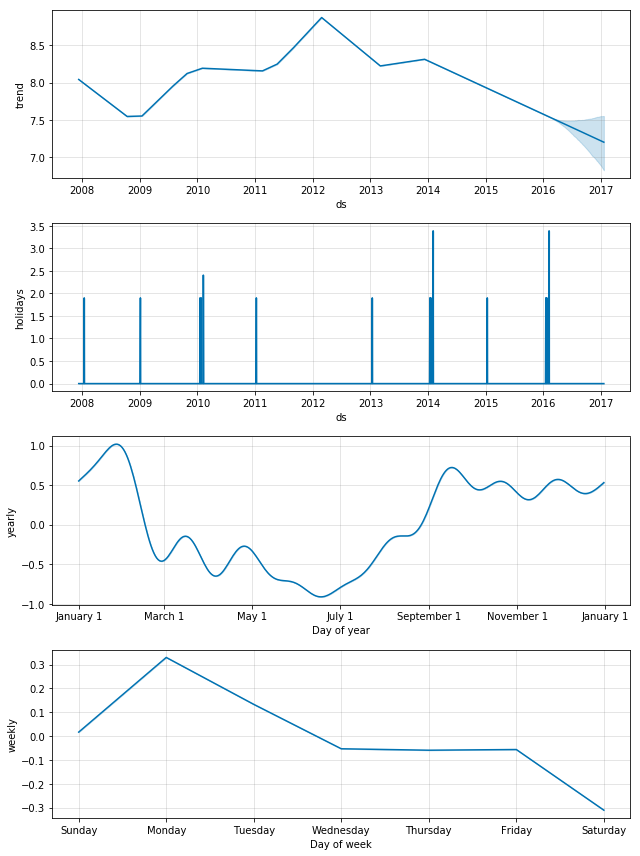

In [9]:
m.plot_components(forecast);

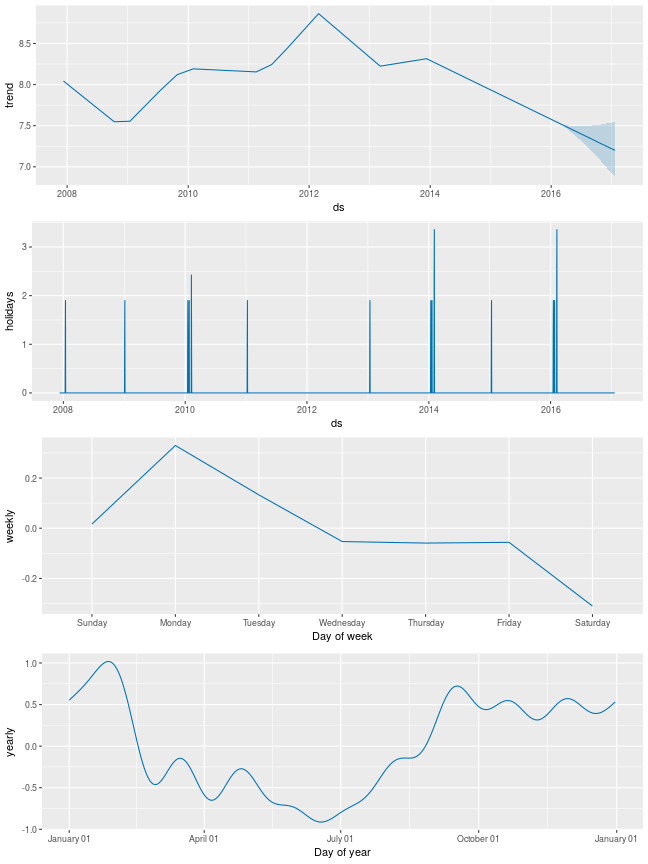

In [10]:
%%R -w 9 -h 12 -u in
prophet_plot_components(m, forecast);

Individual holidays can be plotted using the `plot_forecast_component` method (Python) or function (R). For example, `m.plot_forecast_component(forecast, 'superbowl')` in Python and `plot_forecast_component(forecast, 'superbowl')` in R to plot just the superbowl holiday component.

### Fourier Order for Seasonalities

Seasonalities are estimated using a partial Fourier sum. See [the paper](https://peerj.com/preprints/3190/) for complete details, and [this figure on Wikipedia](https://en.wikipedia.org/wiki/Fourier_series#/media/File:Fourier_Series.svg) for an illustration of how a partial Fourier sum can approximate an aribtrary periodic signal. The number of terms in the partial sum (the order) is a parameter that determines how quickly the seasonality can change. To illustrate this, consider the Peyton Manning data from the Quickstart. The default Fourier order for yearly seasonality is 10, which produces this fit:

Initial log joint probability = -19.4685
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


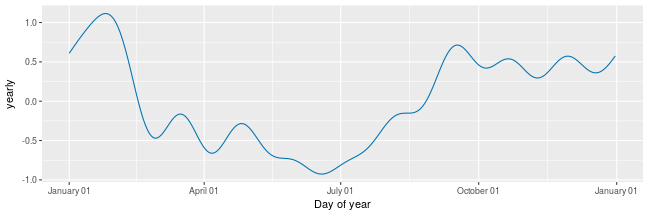

In [11]:
%%R -w 9 -h 3 -u in
m <- prophet(df)
prophet:::plot_yearly(m)

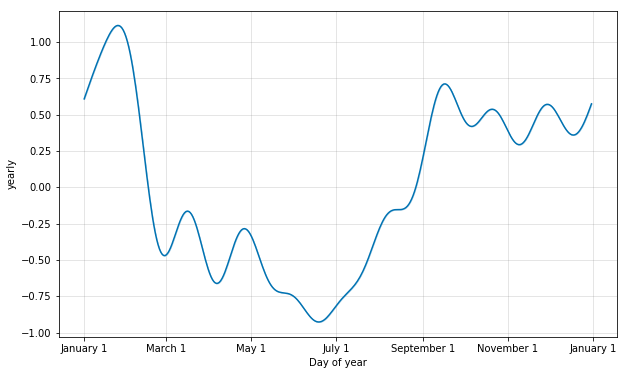

In [12]:
from fbprophet.plot import plot_yearly
m = Prophet().fit(df)
a = plot_yearly(m)

The default values are often appropriate, but they can be increased when the seasonality needs to fit higher-frequency changes, and generally be less smooth. The Fourier order can be specified for each built-in seasonality when instantiating the model, here it is increased to 20:

Initial log joint probability = -19.4685
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


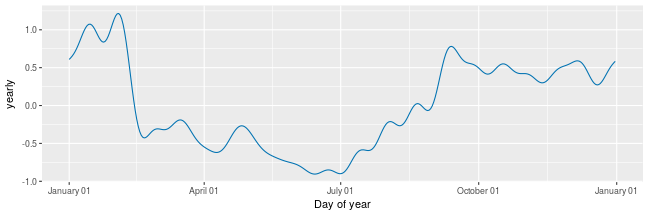

In [13]:
%%R -w 9 -h 3 -u in
m <- prophet(df, yearly.seasonality = 20)
prophet:::plot_yearly(m)

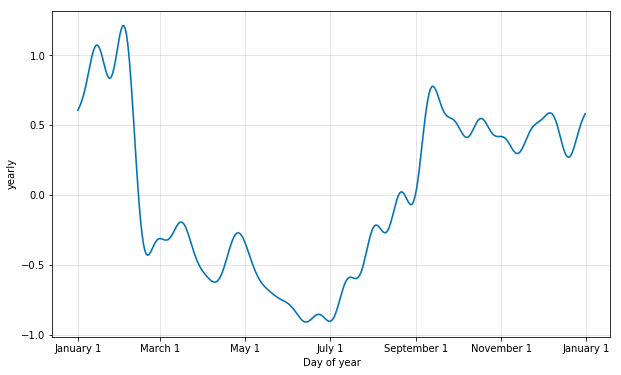

In [14]:
from fbprophet.plot import plot_yearly
m = Prophet(yearly_seasonality=20).fit(df)
a = plot_yearly(m)

Increasing the number of Fourier terms allows the seasonality to fit faster changing cycles, but can also lead to overfitting: $N$ Fourier terms corresponds to $2N$ variables used for modeling the cycle

### Specifying Custom Seasonalities

Prophet will by default fit weekly and yearly seasonalities, if the time series is more than two cycles long. It will also fit daily seasonality for a sub-daily time series. You can add other seasonalities (monthly, quarterly, hourly) using the `add_seasonality` method (Python) or function (R).

The inputs to this function are a name, the period of the seasonality in days, and the Fourier order for the seasonality. For reference, by default Prophet uses a Fourier order of 3 for weekly seasonality and 10 for yearly seasonality. An optional input to `add_seasonality` is the prior scale for that seasonal component - this is discussed below.

As an example, here we fit the Peyton Manning data from the Quickstart, but replace the weekly seasonality with monthly seasonality. The monthly seasonality then will appear in the components plot:

Initial log joint probability = -19.4685
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


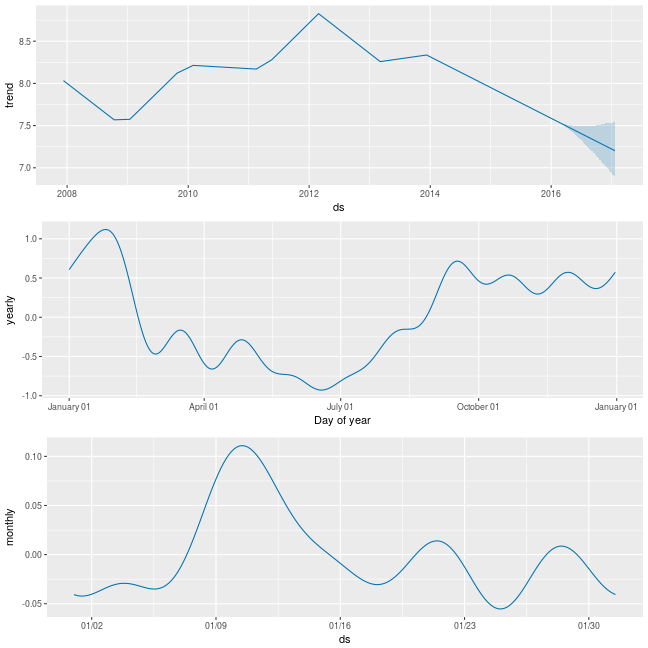

In [15]:
%%R -w 9 -h 9 -u in
m <- prophet(weekly.seasonality=FALSE)
m <- add_seasonality(m, name='monthly', period=30.5, fourier.order=5)
m <- fit.prophet(m, df)
forecast <- predict(m, future)
prophet_plot_components(m, forecast)

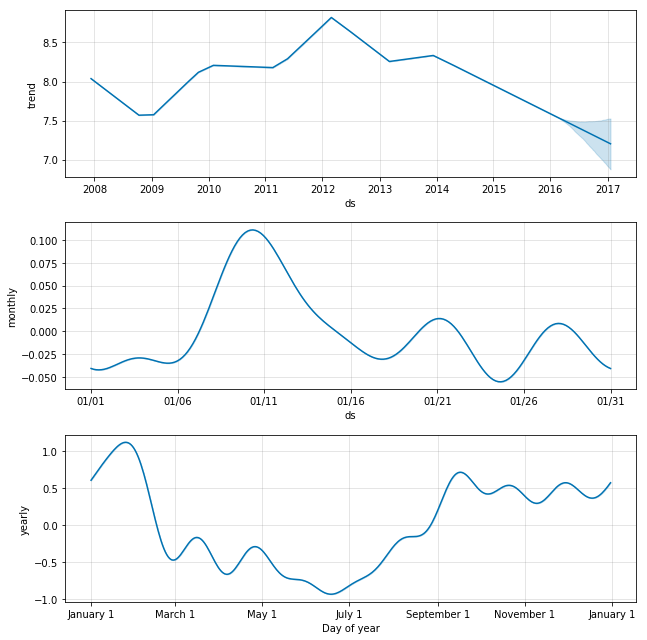

In [16]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(df).predict(future)
m.plot_components(forecast);

### Prior scale for holidays and seasonality
If you find that the holidays are overfitting, you can adjust their prior scale to smooth them using the parameter `holidays_prior_scale`. By default this parameter is 10, which provides very little regularization. Reducing this parameter dampens holiday effects:

In [17]:
%%R
m <- prophet(df, holidays = holidays, holidays.prior.scale = 0.05)
forecast <- predict(m, future)
forecast %>% 
  select(ds, playoff, superbowl) %>% 
  filter(abs(playoff + superbowl) > 0) %>%
  tail(10)

Initial log joint probability = -19.4685
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
           ds  playoff superbowl
17 2014-02-02 1.216714 0.9343464
18 2014-02-03 1.858898 0.9939908
19 2015-01-11 1.216714 0.0000000
20 2015-01-12 1.858898 0.0000000
21 2016-01-17 1.216714 0.0000000
22 2016-01-18 1.858898 0.0000000
23 2016-01-24 1.216714 0.0000000
24 2016-01-25 1.858898 0.0000000
25 2016-02-07 1.216714 0.9343464
26 2016-02-08 1.858898 0.9939908


In [18]:
m = Prophet(holidays=holidays, holidays_prior_scale=0.05).fit(df)
forecast = m.predict(future)
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
    ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.205344,0.963327
2191,2014-02-03,1.851992,0.991010
2532,2015-01-11,1.205344,0.000000
2533,2015-01-12,1.851992,0.000000
2901,2016-01-17,1.205344,0.000000
2902,2016-01-18,1.851992,0.000000
2908,2016-01-24,1.205344,0.000000
2909,2016-01-25,1.851992,0.000000
2922,2016-02-07,1.205344,0.963327
2923,2016-02-08,1.851992,0.991010


The magnitude of the holiday effect has been reduced compared to before, especially for superbowls, which had the fewest observations. There is a parameter `seasonality_prior_scale` which similarly adjusts the extent to which the seasonality model will fit the data.

Prior scales can be set separately for individual holidays by including a column `prior_scale` in the holidays dataframe. Prior scales for individual seasonalities can be passed as an argument to `add_seasonality`. For instance, the prior scale for just weekly seasonality can be set using:

In [19]:
m = Prophet()
m.add_seasonality(
    name='weekly', period=7, fourier_order=3, prior_scale=0.1);

In [20]:
%%R
m <- prophet()
m <- add_seasonality(
  m, name='weekly', period=7, fourier.order=3, prior.scale=0.1)

### Additional regressors
Additional regressors can be added to the linear part of the model using the `add_regressor` method or function. A column with the regressor value will need to be present in both the fitting and prediction dataframes. For example, we can add an additional effect on Sundays during the NFL season. On the components plot, this effect will show up in the 'extra_regressors' plot:

Initial log joint probability = -19.4685
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


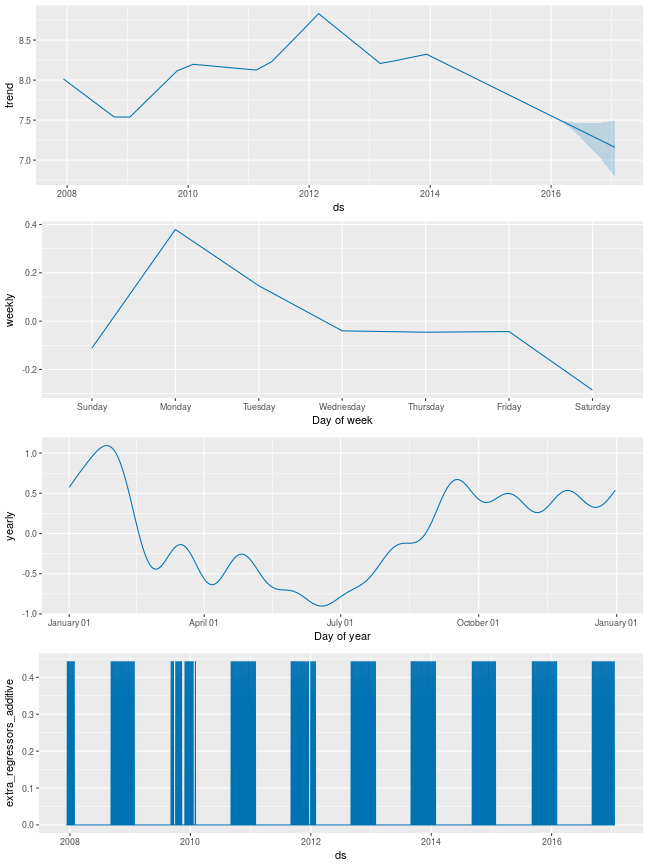

In [21]:
%%R -w 9 -h 12 -u in
nfl_sunday <- function(ds) {
  dates <- as.Date(ds)
  month <- as.numeric(format(dates, '%m'))
  as.numeric((weekdays(dates) == "Sunday") & (month > 8 | month < 2))
}
df$nfl_sunday <- nfl_sunday(df$ds)

m <- prophet()
m <- add_regressor(m, 'nfl_sunday')
m <- fit.prophet(m, df)

future$nfl_sunday <- nfl_sunday(future$ds)

forecast <- predict(m, future)
prophet_plot_components(m, forecast)

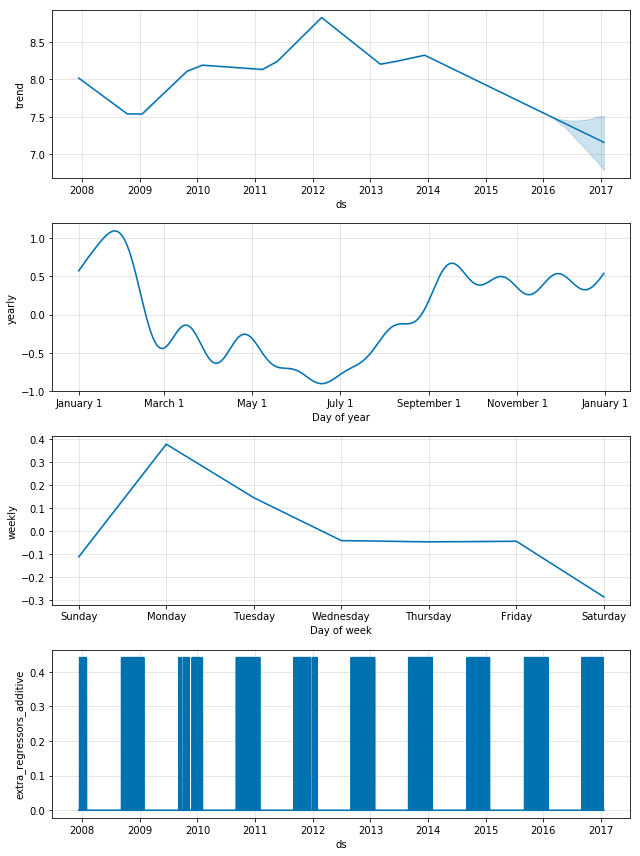

In [22]:
def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0
df['nfl_sunday'] = df['ds'].apply(nfl_sunday)

m = Prophet()
m.add_regressor('nfl_sunday')
m.fit(df)

future['nfl_sunday'] = future['ds'].apply(nfl_sunday)

forecast = m.predict(future)
m.plot_components(forecast);

NFL Sundays could also have been handled using the "holidays" interface described above, by creating a list of past and future NFL Sundays. The `add_regressor` function provides a more general interface for defining extra linear regressors, and in particular does not require that the regressor be a binary indicator. Another time series could be used as a regressor, although its future values would have to be known. The regressor cannot be constant in the training data; fitting will exit with an error if it is.

The `add_regressor` function has optional arguments for specifying the prior scale (holiday prior scale is used by default) and whether or not the regressor is standardized - see the docstring with `help(Prophet.add_regressor)` in Python and `?add_regressor` in R. Note that regressors must be added prior to model fitting.

The extra regressor must be known for both the history and for future dates. It thus must either be something that has known future values (such as `nfl_sunday`), or something that has separately been forecasted elsewhere. Prophet will also raise an error if the regressor is constant throughout the history, since there is nothing to fit from it.

Extra regressors are put in the linear component of the model, so the underlying model is that the time series depends on the extra regressor as either an additive or multiplicative factor (see the next section for multiplicativity).